# Recovering Code

In [1]:
import numpy as np
from numpy.linalg import inv
import sys
import random
import time
from tensorflow.examples.tutorials.mnist import input_data
import os
import matplotlib.pyplot as plt

data_dir = '../data'
mnist = input_data.read_data_sets(data_dir, one_hot=True)

X_train = mnist.train.images
y_train = mnist.train.labels

X_validation = mnist.validation.images
y_validation = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

def softmax(a):
    a = np.exp(a)
    sum_a = sum(a.T)
    a = np.divide(a.T, sum_a).T
    return a

def relu(z):
    g = np.maximum(0, z)
    return g

def relu_gradient(z):
    g = (z >= 0).astype(int)
    return g

def cross_entropy(y_pred, y_train):
    a = softmax(y_train)*np.log(softmax(y_pred)) + softmax(1-y_train)*np.log(1-softmax(y_pred))
    return (-sum(sum(a)))/len(y_train)

def accuracy(y_pred, y_train):
    a = softmax(y_pred)
    b = softmax(y_train)
    return sum(np.equal(np.argmax(a, axis=1), np.argmax(b, axis=1)))/b.shape[0]

def random_init(L_in, L_out, c=0.12):
    return (np.random.rand(L_out, 1 + L_in) * 2 * c) - c

def predict(X_train, Theta):
    a1 = np.append(np.ones((X_train.shape[0], 1)), X_train, axis=1)
    z2 = np.matmul(a1, Theta[0].T)
    a2 = relu(z2)

    z3 = np.matmul(np.append(np.ones((X_train.shape[0], 1)), a2, axis=1), Theta[1].T)
    return z3

def calc_gradient(X_train, y_train, Theta, lambda_v, m):

    a1 = np.append(np.ones((X_train.shape[0], 1)), X_train, axis=1)
    z2 = np.matmul(a1, Theta[0].T)
    a2 = relu(z2)

    z3 = np.matmul(np.append(np.ones((X_train.shape[0], 1)), a2, axis=1), Theta[1].T)
    a3 = softmax(z3)

    delta_3 = (a3 - softmax(y_train)).T
    delta_2 = (np.matmul(Theta[1].T, delta_3).T * relu_gradient(np.append(np.ones((z2.shape[0], 1)), z2, axis=1)))[:,1:]

    D_1 = np.matmul(delta_2.T, a1)
    D_2 = np.matmul(delta_3, np.append(np.ones((m, 1)), a2, axis=1))

    T1 = Theta[0][:, 1:]
    T2 = Theta[1][:, 1:]

    Theta1_grad = (1/m) * D_1 + (lambda_v/m) * np.append(np.zeros((Theta[0].shape[0], 1)), T1, axis=1)
    Theta2_grad = (1/m) * D_2 + (lambda_v/m) * np.append(np.zeros((Theta[1].shape[0], 1)), T2, axis=1)
    return [Theta1_grad,Theta2_grad]

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


### Printing error rates

In [2]:
Theta = np.load('../models/NP_NN_128.npy')

y_train_pred = predict(X_train, Theta)
train_error = 1 - accuracy(y_train_pred, y_train)
train_loss = cross_entropy(y_train_pred, y_train)

y_test_pred = predict(X_test, Theta)
test_error = 1 - accuracy(y_test_pred, y_test)
test_loss = cross_entropy(y_test_pred, y_test)
print("train error = {:.6f}, test error = {:.6f}".format(train_error, test_error))

train error = 0.038218, test error = 0.040700


### Printing confusion Matrix

In [3]:
from sklearn.metrics import confusion_matrix

train_pred = np.argmax(y_train_pred, axis=1)
train_labels = np.argmax(y_train, axis=1)

test_pred = np.argmax(y_test_pred, axis=1)
test_labels = np.argmax(y_test, axis=1)

train_confuse = confusion_matrix(train_labels, train_pred)
test_confuse = confusion_matrix(test_labels, test_pred)

In [4]:
train_confuse

array([[5334,    1,    7,    1,    7,    5,   25,    0,   53,   11],
       [   2, 6065,   37,   14,   15,    1,    3,    9,   29,    4],
       [  21,   16, 5231,   19,   41,    2,   23,   41,   69,    7],
       [   5,    6,   79, 5324,    3,   46,    9,   35,  104,   27],
       [   6,   15,    7,    0, 5099,    5,   25,    9,   29,  112],
       [  26,    7,   18,   60,   11, 4733,   57,    7,   45,   23],
       [  24,   12,   14,    0,   10,   45, 5270,    0,   42,    0],
       [  14,   26,   55,   11,   45,    2,    4, 5450,   18,   90],
       [  14,   29,   18,   28,   10,   20,   28,    5, 5208,   29],
       [  19,   11,    5,   50,   57,   19,    3,   51,   55, 5184]])

In [5]:
test_confuse

array([[ 969,    0,    2,    1,    0,    0,    4,    1,    3,    0],
       [   0, 1119,    2,    3,    0,    0,    4,    1,    6,    0],
       [   5,    2,  985,    7,    7,    0,    5,    6,   14,    1],
       [   0,    0,   13,  963,    0,    7,    0,    7,   15,    5],
       [   1,    0,    6,    0,  934,    0,    5,    1,    7,   28],
       [   6,    2,    0,   25,    2,  832,   10,    3,    8,    4],
       [   8,    3,    0,    1,    5,    8,  924,    1,    8,    0],
       [   2,   11,   17,    3,    8,    0,    0,  970,    2,   15],
       [   4,    1,    2,    6,    3,    0,    8,    0,  946,    4],
       [   6,    7,    1,    7,   15,    3,    0,    4,   15,  951]])

training confusion matrix
Confusion matrix, without normalization


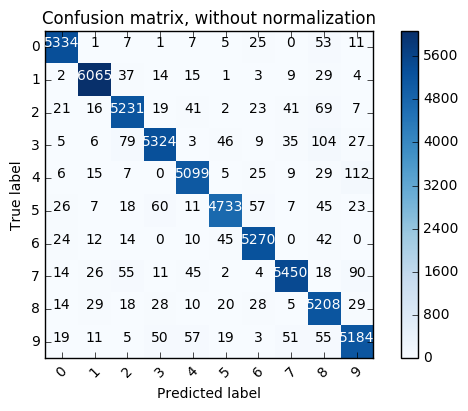

testing confusion matrix
Confusion matrix, without normalization


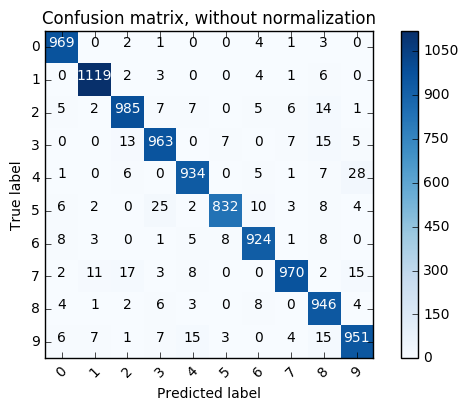

In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=10)
class_names = [str(i) for i in range(10)]
# Plot non-normalized confusion matrix
print("training confusion matrix")
plt.figure()
plot_confusion_matrix(train_confuse, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print("testing confusion matrix")
np.set_printoptions(precision=10)
class_names = [str(i) for i in range(10)]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_confuse, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

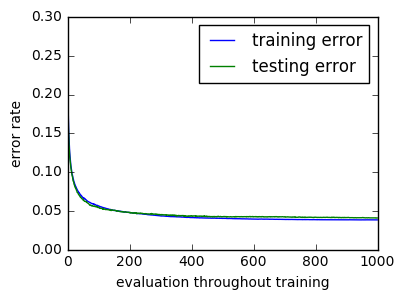

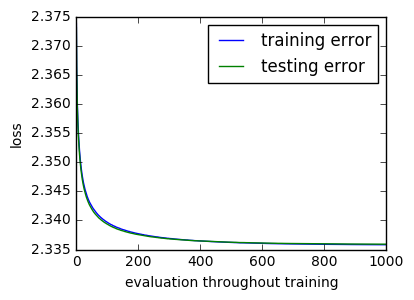

In [7]:
train_error_list = np.load("../models/NP_NN_128_train_error_list.npy")
test_error_list = np.load("../models/NP_NN_128_test_error_list.npy")
train_loss_list = np.load("../models/NP_NN_128_train_loss_list.npy")
test_loss_list = np.load("../models/NP_NN_128_test_loss_list.npy")


plt.figure(num=None, figsize=(4, 3), dpi=128, facecolor='w', edgecolor='k')
plt.plot(train_error_list)
plt.plot(test_error_list)
plt.xlabel("evaluation throughout training")
plt.ylabel("error rate")
plt.legend(["training error", "testing error"])
plt.show()


plt.figure(num=None, figsize=(4, 3), dpi=128, facecolor='w', edgecolor='k')
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel("evaluation throughout training")
plt.ylabel("loss")
plt.legend(["training error", "testing error"])
plt.show()

In [8]:
print("""
\\begin{table}[H]
\t\\centering
\t\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\t\t\\hline
\t\ttrain epoch\\textbackslash error & train error & test error \\\\
\t\t\\hline
""")
for i in range(10):
    print("\t\t{} & {:.4f} & {:.4f} \\\\".format(int(len(train_error_list) * i/10), train_error_list[int(len(train_error_list) * i/10)], test_error_list[int(len(train_error_list) * i/10)]))
    print("\t\t\\hline")
print("\t\t{} & {:.4f} & {:.4f} \\\\".format(len(train_error_list)-1, train_error_list[-1], test_error_list[-1]))
print("\t\t\\hline")
print("""
\t\\end{tabular}
\t\\caption{training and testing error}
\t\\label{tab:my_label}
\\end{table}
""")


\begin{table}[H]
	\centering
	\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
		\hline
		train epoch\textbackslash error & train error & test error \\
		\hline

		0 & 0.2919 & 0.2799 \\
		\hline
		100 & 0.0563 & 0.0542 \\
		\hline
		200 & 0.0476 & 0.0477 \\
		\hline
		300 & 0.0433 & 0.0447 \\
		\hline
		400 & 0.0411 & 0.0435 \\
		\hline
		500 & 0.0401 & 0.0423 \\
		\hline
		600 & 0.0394 & 0.0421 \\
		\hline
		700 & 0.0388 & 0.0421 \\
		\hline
		800 & 0.0384 & 0.0416 \\
		\hline
		900 & 0.0383 & 0.0412 \\
		\hline
		999 & 0.0382 & 0.0407 \\
		\hline

	\end{tabular}
	\caption{training and testing error}
	\label{tab:my_label}
\end{table}

